In [1]:
library(ggplot2)
library(gridExtra)
library(rstan)
library(rstansensitivity)

rstan_options(auto_write=TRUE)
options(warn=1) # Display Stan warnings as they occur.
set.seed(42) # For reproducibility

Loading required package: StanHeaders
rstan (Version 2.17.3, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
Loading required package: dplyr

Attaching package: ‘dplyr’

The following object is masked from ‘package:gridExtra’:

    combine

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: reshape2


In [2]:
git_repo_loc <- system("git rev-parse --show-toplevel", intern=TRUE)
example_path <- file.path(git_repo_loc, "examples/earnings_vary_si")

base_model_name <- file.path(example_path, "models/earnings_vary_si.stan")
data_path <- file.path(example_path, "earnings_vary_si.data.R")

# Load the data into a list and set sampling parameters.
stan_data <- new.env()
source(data_path, local=stan_data)
stan_data <- as.list(stan_data)

iters <- 10000
adapt_delta <- 0.99

In [3]:
# Compile the models.
model_name <- GenerateSensitivityFromModel(base_model_name)
model <- stan_model(paste(model_name, "_generated.stan", sep=""))
stan_sensitivity_list <- GetStanSensitivityModel(model_name, stan_data)

In file included from /usr/local/lib/R/site-library/BH/include/boost/config.hpp:39:0,
                 from /usr/local/lib/R/site-library/BH/include/boost/math/tools/config.hpp:13,
                 from /usr/local/lib/R/site-library/StanHeaders/include/stan/math/rev/core/var.hpp:7,
                 from /usr/local/lib/R/site-library/StanHeaders/include/stan/math/rev/core/gevv_vvv_vari.hpp:5,
                 from /usr/local/lib/R/site-library/StanHeaders/include/stan/math/rev/core.hpp:12,
                 from /usr/local/lib/R/site-library/StanHeaders/include/stan/math/rev/mat.hpp:4,
                 from /usr/local/lib/R/site-library/StanHeaders/include/stan/math.hpp:4,
                 from /usr/local/lib/R/site-library/StanHeaders/include/src/stan/model/model_header.hpp:4,
                 from file24505a82e2f.cpp:8:
/usr/local/lib/R/site-library/BH/include/boost/config/compiler/gcc.hpp:186:0: warning: "BOOST_NO_CXX11_RVALUE_REFERENCES" redefined
 #  define BOOST_NO_CXX11_RVALUE_REF

In [4]:
# Run the sampler.
sampling_time <- Sys.time()
sampling_result <- sampling(
  model, data=stan_data, iter=iters, chains=1, control=list(adapt_delta=adapt_delta))
sampling_time <- Sys.time() - sampling_time
print(sampling_time)


SAMPLING FOR MODEL 'earnings_vary_si_generated' NOW (CHAIN 1).

Gradient evaluation took 6.8e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.68 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 2000 / 10000 [ 20%]  (Warmup)
Iteration: 3000 / 10000 [ 30%]  (Warmup)
Iteration: 4000 / 10000 [ 40%]  (Warmup)
Iteration: 5000 / 10000 [ 50%]  (Warmup)
Iteration: 5001 / 10000 [ 50%]  (Sampling)
Iteration: 6000 / 10000 [ 60%]  (Sampling)
Iteration: 7000 / 10000 [ 70%]  (Sampling)
Iteration: 8000 / 10000 [ 80%]  (Sampling)
Iteration: 9000 / 10000 [ 90%]  (Sampling)
Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 67.5529 seconds (Warm-up)
               89.0353 seconds (Sampling)
               156.588 seconds (Total)



Warning message:
“There were 4 divergent transitions after warmup. Increasing adapt_delta above 0.99 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Warning message:
“There were 1 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”

Time difference of 2.610455 mins


In [5]:
# Calculate the sensitivity.
sens_time <- Sys.time()
sens_result <- GetStanSensitivityFromModelFit(sampling_result, stan_sensitivity_list)
tidy_results <- GetTidyResult(sens_result)
sens_time <- Sys.time() - sens_time
print(sens_time)

Evaluating model at the MCMC draws for chain  1 .
  |======================================================================| 100%


Warning message in mcmcse::mcse.multi(arg_draws):
“You either need more samples or x is not full column rank”Warning message in mcmcse::mcse.multi(arg_draws):
“You either need more samples or x is not full column rank”Warning message in log(sig.eigen):
“NaNs produced”Warning message in mcmcse::mcse.multi(par_draws):
“You either need more samples or x is not full column rank”Warning message in log(sig.eigen):
“NaNs produced”Warning message in mcmcse::mcse.multi(par_draws):
“You either need more samples or x is not full column rank”Warning message in log(sig.eigen):
“NaNs produced”Warning message in mcmcse::mcse.multi(par_draws):
“You either need more samples or x is not full column rank”Warning message in log(sig.eigen):
“NaNs produced”

Time difference of 7.467873 secs


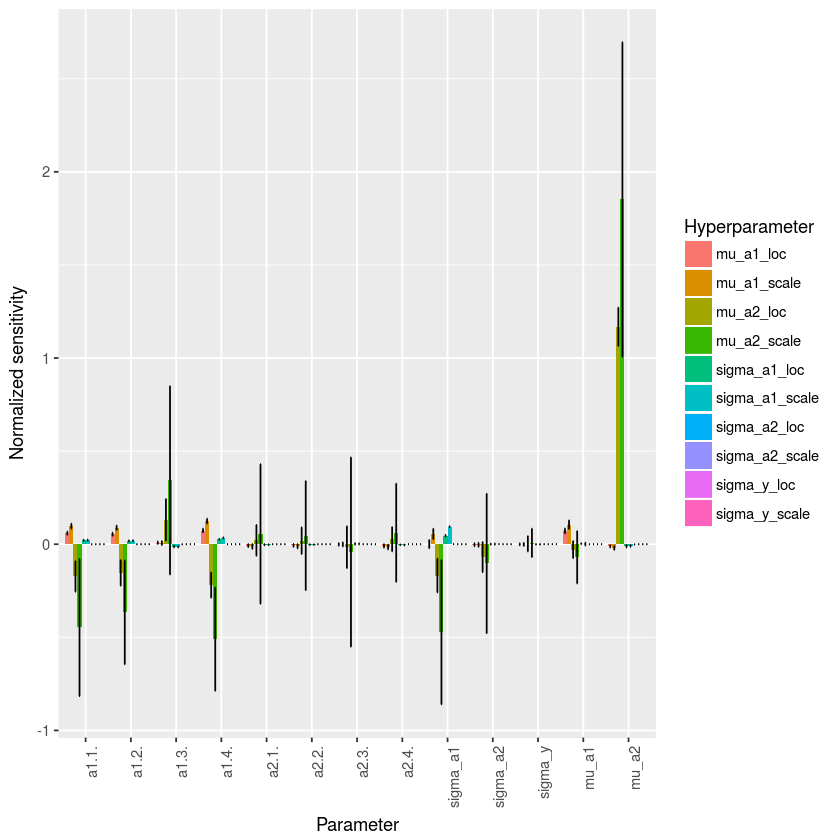

In [6]:
PlotSensitivities(tidy_results)

In [7]:
# Refit with a range of values for the hyperparameter.
StanResultToDataframe <- function(sampling_result) {
  sampling_df <- data.frame(summary(sampling_result)$summary)
  sampling_df$parameter <- make.names(rownames(sampling_df))
  return(sampling_df)
}

hyperparam_name <- "mu_a2_scale"
num_refits <- 10
hyperparam_min_offset <- -0.8
hyperparam_max_offset <- 1.0

hyperparam_vals <- seq(stan_data[[hyperparam_name]] + hyperparam_min_offset,
                     stan_data[[hyperparam_name]] + hyperparam_max_offset,
                     length.out=num_refits)

In [ ]:
summary_list <- list()
sampling_result_list <- list()
refit_time <- Sys.time()
for (val in hyperparam_vals) {
    cat(sprintf("Value: %f", val))
    stan_data_perturbed <- stan_data
    stan_data_perturbed[[hyperparam_name]] <- val
    sampling_result_perturbed <-
      sampling(model, data=stan_data_perturbed, iter=iters, chains=1,
               control=list(adapt_delta=adapt_delta))
    sampling_result_list[[length(sampling_result_list) + 1]] <- sampling_result_perturbed
    sens_summary_peturbed <-
      StanResultToDataframe(sampling_result_perturbed) %>%
      mutate(hyperparameter=hyperparam_name, hyperparameter_val=val)
    summary_list[[length(summary_list) + 1]] <- sens_summary_peturbed
}
refit_time <- Sys.time() - refit_time



Value: 0.200000
SAMPLING FOR MODEL 'earnings_vary_si_generated' NOW (CHAIN 1).

Gradient evaluation took 5.7e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.57 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 2000 / 10000 [ 20%]  (Warmup)
Iteration: 3000 / 10000 [ 30%]  (Warmup)
Iteration: 4000 / 10000 [ 40%]  (Warmup)
Iteration: 5000 / 10000 [ 50%]  (Warmup)
Iteration: 5001 / 10000 [ 50%]  (Sampling)
Iteration: 6000 / 10000 [ 60%]  (Sampling)
Iteration: 7000 / 10000 [ 70%]  (Sampling)
Iteration: 8000 / 10000 [ 80%]  (Sampling)
Iteration: 9000 / 10000 [ 90%]  (Sampling)
Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 71.4119 seconds (Warm-up)
               87.2203 seconds (Sampling)
               158.632 seconds (Total)



Warning message:
“There were 1 divergent transitions after warmup. Increasing adapt_delta above 0.99 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”

Value: 0.400000
SAMPLING FOR MODEL 'earnings_vary_si_generated' NOW (CHAIN 1).

Gradient evaluation took 5.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.52 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 2000 / 10000 [ 20%]  (Warmup)
Iteration: 3000 / 10000 [ 30%]  (Warmup)
Iteration: 4000 / 10000 [ 40%]  (Warmup)
Iteration: 5000 / 10000 [ 50%]  (Warmup)
Iteration: 5001 / 10000 [ 50%]  (Sampling)
Iteration: 6000 / 10000 [ 60%]  (Sampling)
Iteration: 7000 / 10000 [ 70%]  (Sampling)
Iteration: 8000 / 10000 [ 80%]  (Sampling)
Iteration: 9000 / 10000 [ 90%]  (Sampling)
Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 71.5995 seconds (Warm-up)
               53.0101 seconds (Sampling)
               124.61 seconds (Total)

Value: 0.600000
SAMPLING FOR MODEL 'earnings_vary_si_generated' NOW (CHAIN 1).

Gradient evaluation took 4.9e-05 seconds
1000 tran

Warning message:
“There were 3 divergent transitions after warmup. Increasing adapt_delta above 0.99 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”

Value: 0.800000
SAMPLING FOR MODEL 'earnings_vary_si_generated' NOW (CHAIN 1).

Gradient evaluation took 4.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.46 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 10000 [  0%]  (Warmup)
Iteration: 1000 / 10000 [ 10%]  (Warmup)
Iteration: 2000 / 10000 [ 20%]  (Warmup)
Iteration: 3000 / 10000 [ 30%]  (Warmup)
Iteration: 4000 / 10000 [ 40%]  (Warmup)
Iteration: 5000 / 10000 [ 50%]  (Warmup)
Iteration: 5001 / 10000 [ 50%]  (Sampling)
Iteration: 6000 / 10000 [ 60%]  (Sampling)
Iteration: 7000 / 10000 [ 70%]  (Sampling)
Iteration: 8000 / 10000 [ 80%]  (Sampling)
Iteration: 9000 / 10000 [ 90%]  (Sampling)
Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 64.2768 seconds (Warm-up)
               92.9485 seconds (Sampling)
               157.225 seconds (Total)



Warning message:
“There were 1 divergent transitions after warmup. Increasing adapt_delta above 0.99 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”

In [ ]:
print("Refit time: ")
print(refit_time)

In [ ]:
perturbed_df <-
    do.call(rbind, summary_list) %>%
    inner_join(tidy_results, by=c("parameter", "hyperparameter")) %>%
    inner_join(StanResultToDataframe(sampling_result),
               by="parameter", suffix=c("", ".orig"))

Our later analysis will motivate the following "corrected" model.  In order to run all the sampling in a single worksheet, we include this code here.

In [ ]:
fixed_base_model_name <- file.path(example_path, "models/earnings_vary_si_corrected.stan")
fixed_model_name <- GenerateSensitivityFromModel(fixed_base_model_name)
fixed_model <- stan_model(paste(fixed_model_name, "_generated.stan", sep=""))
fixed_stan_sensitivity_list <- GetStanSensitivityModel(fixed_model_name, stan_data)

In [ ]:
fixed_stan_data <- new.env()
source(data_path, local=fixed_stan_data)
fixed_stan_data <- as.list(fixed_stan_data)
fixed_stan_data$mu_a1_scale <- 10
fixed_stan_data$mu_a2_scale <- 10

fixed_stan_data$sigma_a1_scale <- 10
fixed_stan_data$sigma_a2_scale <- 10

fixed_sampling_result <- sampling(
  model, data=fixed_stan_data, iter=iters,
  chains=1, control=list(adapt_delta=adapt_delta))

In [ ]:
fixed_sens_result <- GetStanSensitivityFromModelFit(fixed_sampling_result, stan_sensitivity_list)
fixed_tidy_results <- GetTidyResult(fixed_sens_result)

In [ ]:
refit_filename <- file.path(example_path, "earnings_vary_si_refit_results.Rdata")
cat("Saving to\n", refit_filename, "\n")
save(model_name, tidy_results, stan_data, fixed_stan_data,
     perturbed_df, summary_list,
     sampling_result,
     sampling_result_list,
     fixed_sampling_result, fixed_tidy_results,
     sampling_time, sens_time, refit_time,
     hyperparam_name, hyperparam_vals,
     file=refit_filename)